In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets.base import Bunch
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

/home/deepankaracharyya/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Read in the data and explore it

In [2]:
#attribute list
col_names = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income',]

In [3]:
#reading in the data
adult_data_train=pd.read_csv('adult.data',names=col_names)
adult_data_predict= pd.read_csv('adult.test', names=col_names, skiprows=1)

In [5]:
#Data Exploration
adult_data_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


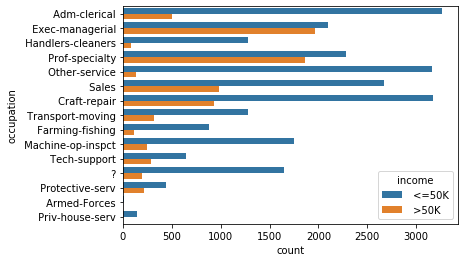

In [6]:
sns.countplot(y='occupation', hue='income', data=adult_data_train,)

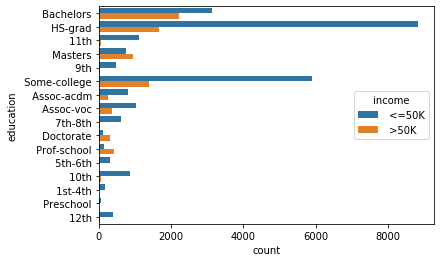

In [7]:
sns.countplot(y='education', hue='income', data=adult_data_train,)

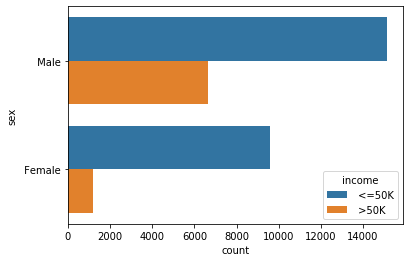

In [8]:
sns.countplot(y='sex', hue='income', data=adult_data_train,)

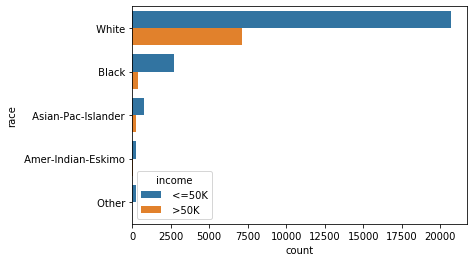

In [9]:
sns.countplot(y='race', hue='income', data=adult_data_train,)

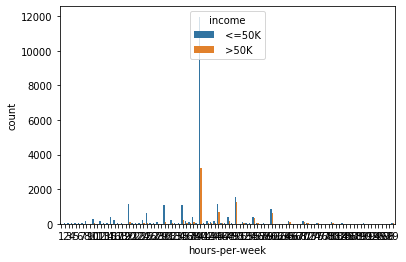

In [10]:
sns.countplot(x='hours-per-week', hue='income', data=adult_data_train,)

# Preprocessing the data

In [12]:
#1. Replace the Nan/Missing data values with mode values
attr_list=list(col_names)
attr_list.remove('income')

for col in attr_list:
    mode=adult_data_train[col].mode()
    adult_data_train[col].fillna(mode)

for col in attr_list:
    mode=adult_data_predict[col].mode()
    adult_data_predict[col].fillna(mode)

In [13]:
#2. For encoding the categorical data
class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None.
    """
    def __init__(self, columns=None):
        self.columns  = columns
        self.encoders = None
    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode.
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns
        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns
        }
        return self
    def transform(self, data):
        """
        Uses the encoders to transform a data frame.
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])
        return output
    
encoder = EncodeCategorical(col_names)
data = encoder.fit_transform(adult_data_train)
data_predict=encoder.fit_transform(adult_data_predict)

In [14]:
#3. Split into the train and test sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(data,adult_data_train['income'],test_size=0.2)

# The KNN Model

Text(0, 0.5, 'Testing Accuracy')

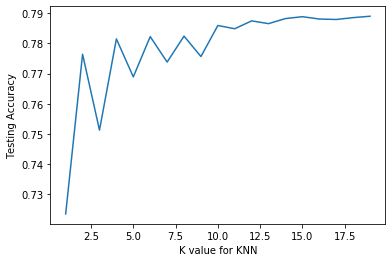

In [27]:
#1.Find the optimum value of k
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_range=range(1,20)
scores={}
scores_list=[]

for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred=knn.predict(X_test)
    sc=metrics.accuracy_score(y_test,y_pred)
    scores[k]=sc
    scores_list.append(sc)
    
plt.plot(k_range,scores_list)
plt.xlabel('K value for KNN')
plt.ylabel('Testing Accuracy')

In [28]:
#Train the knn model with optimum value of k
k_optimum=15
knn=KNeighborsClassifier(n_neighbors=k_optimum)
knn.fit(X_train,y_train)
knn.score(X_test, y_test)

0.7888837709196991

In [29]:
#predict the value for the test sets
prediction=knn.predict(data_predict)

In [32]:
pred=pd.DataFrame(prediction,columns=['pred'])

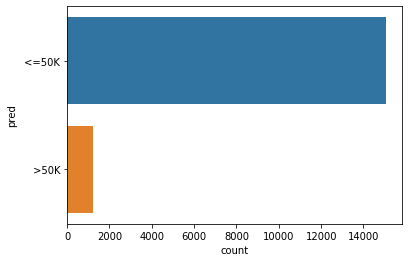

In [33]:
sns.countplot(y='pred',data=pred,)